# Tableau project

## Import libraries

In [1]:
import pymongo
MongoClient = pymongo.MongoClient
client = MongoClient()
from geopy.geocoders import Nominatim
import pandas as pd
import plotly as plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import *
import matplotlib.pyplot as plt
%matplotlib inline

## Development Code


##### Crear el cliente de bbdd y la llamada para filtrar los datos

In [2]:
db = client.companies

##### Esta consulta es muy específica, ya que se ha filtrado teniendo en cuenta toda la información dada en el enunciado del proyectos. Para que una empresa pase este filtro, tiene que cumplir cada uno de los siguientes casos:
* Pertenecer a una de las siguientes categorías: "software","web","mobile" o "games_video"
* Estar fundada despues del año 2000 y además que no haya quebrado
* Contenter puestos de trabajo cuyo título sea "Software Engineer" y además contener alguno de los siguientes puestos:
 - "Designer", "Creative", "UX" o "UI"
 - "Developers"
 - "Executive" o "Manager"

In [3]:
filterquery ={"$and":
    [
     {"$or":
        [
            {"category_code": "software"},
            {"category_code": "web"},
            {"category_code": "mobile"},
            {"category_code": "games_video"}
        ]},
      {"$and":
         [
             {"founded_year": {"$gt":2000}},
             {"$or":
              [
                 {"deadpooled_year":{"$eq": None}},
                 {"deadpooled_year":{"$exists":False}}
              ]
             }
         ]},
      {"$and":
       [
          {"relationships.title":{'$regex':'Software Engineer'}},
          {"$or":
             [
                 {"$or":
                     [
                         {"relationships.title":{'$regex':'[Dd]esigner'}},
                         {"relationships.title":{'$regex':'[Cc]reative'}},
                         {"relationships.title":{'$regex':'U[XI]'}},
                     ]},
                 {"relationships.title":{'$regex':'[Dd]evelopers'}},
                 {"$or":
                     [
                         {"relationships.title":{'$regex':'[Ee]xecutive'}},
                         {"relationships.title":{'$regex':'[Mm]anager'}}
                     ]} 
            ]
          }
       ]
      }
    ]
}

##### Se han creado las siguientes funciones con el objetivo de obtener los datos específicos que buscamos. Estas funciones se explican a continuación:
* filterData: Recibe un cursor y un booleano(el cual se utiliza para devolver un resultado u otro en función de si estamos filtrando en la colección inicial o en la que ya está limpia). Su finalidad es obtener un JSON con todas las compañias que pasen el filtro especificado.
* toGeoJSON: Recibe un array del cual obtiene la latitud y la longitud. Una vez tenga estos datos, crea un tipo "Point" con estas cordenadas. En esta función he tenido en cuenta las compañias que no cuentan con campos de latitud y longitud, por lo que para ellas he comprobado si contienen valores validos en los campos "address1" y "city", y con estos datos he obtenido los datos deseados usando el método "geopy.geocoders" de la librería "Nominatim"
* convertCompanies: Recibe la compañia y un booleano, si el booleano es "False" devuelve el resultado de la colección inicial, y si es "True" devuelve el resultado de la colección limpia.

In [4]:
def filterData(cursor, clean=False):
    geoCompanies = list(map(lambda c: convertCompanies(c,clean),cursor))
    return geoCompanies
    
def toGeoJSON(array):
    coor=['','']
    for i in array:
        geolocator = Nominatim(user_agent="tableau-project")
        
        if not i['latitude'] or not i['longitude']:
            if i['address1'] != '' and i['city'] != '' and i['address1'] != None and i['city'] != None:
                location = geolocator.geocode(i['address1'])
                if location != None:
                    coor=[location.longitude,location.latitude]
            elif i['address1'] != '' and not i['address1']:
                location = geolocator.geocode(i['address1'])
                coor=[location.longitude,location.latitude]
        else:
            coor=[i['longitude'],i['latitude']]
    if coor != ['','']:
        return {
            "type":"Point",
            "coordinates":coor
        }

def convertCompanies(company,clean):
    result= {
            "name": company["name"],
            "homepage_url": company["homepage_url"],
            "number_of_employees": company["number_of_employees"],
            "total_money_raised": company["total_money_raised"],
            "category_code":company["category_code"]}
    if not clean:
        result.update({"position": toGeoJSON(company["offices"])})
    else:
        result.update({
            "position": company["position"],
            "near_companies": near_companies(company)
        })
    return result

geoCompanies = filterData(db.companies.find(filterquery))

##### Se crea un dataFrame con los datos obtenidos en el filtrado y se importa a un fichero JSON para posteriormente crear una nueva colección con estos datos

In [5]:
df = pd.DataFrame(geoCompanies)
df.to_json('clean_companies.json',orient="records", lines=True)

##### Crear el cliente de bbdd para la colección limpia

In [6]:
db_clean = client.clean_companies

##### Se crea una función, la cual obtiene el número de empresas que se encuentran en un radio de 2km, para cada una de las empresas

In [7]:
def near_companies(array):
    if array['position'] != None:
        coord=array['position']['coordinates']
        value=db_clean.clean_companies.count({"$and":
    [
        {"position":{"$ne":None}},
        {
          "position": {
            "$near": {
              "$geometry": {
                "type": "Point",
                "coordinates": coord
              },
              "$minDistance": 0,
              "$maxDistance":2000
            }
          }
        }
    ]
  })
        return value

##### Se llama a la función filterData para obtener los datos deseados en el nuevo dataFrame

In [8]:
filterquery2={"$and":[{"position":{"$ne":None}},{"total_money_raised":{"$ne":"$0"}}]}
c_n_companies=filterData(db_clean.clean_companies.find(filterquery2),True)


/home/luis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning:

count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere



##### Limpiamos el dataFrame actual, para ello seguimos las siguientes pautas:
* Obtenemos los valores de la latitud y la longitud del campo tipo "Point" para guardarlas en dos columnas distintas.
* Filtramos el dataFrame para quedarnos únicamente con las compañias que tengan 4 o más empresas cerca.
* Creamos un campo denominado ciudad, para ello se ha vuelto a utilizar el método "geopy.geocoders" de la librería "Nominatim"
* Eliminamos los registros que contengan una ganancias iguales a 0(campo "total_money_raised), debido a que no me interesan ya que mi futura empresas tiene que tener ganancias para poder subsistir.
* Obtenemos el valor numérico del campo "total_money_raised" y lo convertimos a float para posteriormente trabajar con el.

In [9]:
df = pd.DataFrame(c_n_companies)

def dataframe_final(df):
    coords_df = pd.DataFrame(pd.DataFrame(df["position"].values.flatten().tolist())["coordinates"].values.tolist())
    clean_df = pd.concat([df,coords_df],axis=1)
    clean_df.drop("position", inplace=True, axis=1)
    clean_df = clean_df.rename({0:"long",1:"lat"}, axis=1)
    clean_df.drop_duplicates(subset =["category_code","name"], 
                         keep = False, inplace = True)
    clean_df.drop(clean_df[clean_df["near_companies"] < 4].index, inplace=True)
    clean_df.drop(clean_df[clean_df["total_money_raised"] == "$0"].index, inplace=True)
    geolocator = Nominatim(user_agent="tableau-project")
    city=[','.join(geolocator.reverse([clean_df.lat.values[i],clean_df.long.values[i]]).address.split(",")[-4:-2]) for i in range(len(clean_df.lat.values))]
    clean_df["city"]=city
    clean_df['total_money_raised']=clean_df['total_money_raised'].str.extract('(\d+\.?\d?)').astype(float)
    return clean_df
data_final=dataframe_final(df)
data_final

,category_code,homepage_url,name,near_companies,number_of_employees,total_money_raised,long,lat,city
3,web,http://seesmic.com,Seesmic,5,13.0,16.0,-122.419204,37.775196,"SF, California"
9,games_video,http://ilike.com,iLike,4,28.0,16.5,-122.323408,47.615313,"King County, Washington"
12,software,http://www.xobni.com,Xobni,13,0.0,41.8,-122.404052,37.789634,"SF, California"
15,web,http://www.disqus.com,Disqus,12,43.0,10.5,-122.397672,37.786906,"SF, California"
20,web,http://www.eventbrite.com,Eventbrite,13,200.0,140.0,-122.390710,37.779507,"SF, California"
21,mobile,http://www.pelago.com,Pelago,4,NaN,22.4,-122.335373,47.607065,"King County, Washington"
25,web,http://hubpages.com,HubPages,12,21.0,8.0,-122.399151,37.787695,"SF, California"
28,games_video,http://www.zynga.com,Zynga,6,115.0,860.0,-122.404234,37.765158,"SF, California"
30,software,http://www.doubletwist.com,doubleTwist,5,NaN,7.5,-122.419204,37.775196,"SF, California"
32,games_video,http://www.playfirst.com,PlayFirst,12,NaN,37.7,-122.401850,37.790346,"SF, California"


##### Obtenemos el JSON final, con el cual vamos a trabajar y vamos a utilizar para obtener el mapa tanto en tableau como con la librería "plotly"

In [10]:
data_final.to_json('visualize_companies.json', orient="records")

##### Creamos una función la cual genera un mapa que contiene los puntos exactos en los que se encuentran las empresas que hemos obtenido durante el proyecto

In [11]:
def map_chart(df):
    mapbox_access_token = 'pk.eyJ1IjoibG1hcnRpbmV6cnVpeml0IiwiYSI6ImNqcnV2NTNycjE3ZnQzeXFzbHk3NXB5MjYifQ.Namsd_wjsdPevALwq2YTmQ'

    site_lat = df.lat
    site_lon = df.long
    locations_name = df.name

    df2 = [
        go.Scattermapbox(
            lat=site_lat,
            lon=site_lon,
            mode='markers',
            marker=dict(
                size=17,
                color='rgb(255, 0, 0)',
                opacity=0.7
            ),
            hoverinfo='text',
            text=locations_name
            
        ),
        go.Scattermapbox(
            lat=site_lat,
            lon=site_lon,
            mode='markers',
            marker=dict(
                size=8,
                color='rgb(242, 177, 172)',
                opacity=0.7
            ),

            hovertext=locations_name+":: url: "+df.homepage_url,
        )]
            
    layout = go.Layout(
        title='Companies',
        autosize=True,
        hovermode='closest',
        showlegend=False,
        mapbox=dict(
            accesstoken=mapbox_access_token,
            bearing=0,
            center=dict(
                lat=38,
                lon=-94
            ),
            pitch=0,
            zoom=3,
            style='light'
        ),
    )
    fig = dict(data=df2, layout=layout)
    plotly.offline.plot(fig, filename='Companies' )
map_chart(data_final)

/home/luis/anaconda3/lib/python3.7/site-packages/plotly/offline/offline.py:635: UserWarning:

Your filename `Companies` didn't end with .html. Adding .html to the end of your file.



##### Una vez hemos obtenido los puntos, analizamos que lugar es el más adecuado en función de una serie de parámetros

Text(0.5, 0, 'City')

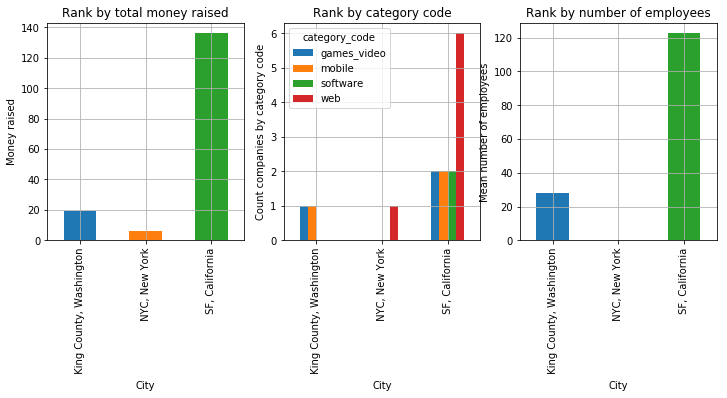

In [12]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))
data_final.groupby(['city'])['total_money_raised'].mean().plot.bar(ax=ax1).grid()
ax1.set_title('Rank by total money raised')
ax1.set_ylabel('Money raised')
ax1.set_xlabel('City')

#2
data_final.groupby(['city','category_code'])['name'].count().unstack('category_code').plot.bar(ax=ax2).grid()
ax2.set_title('Rank by category code')
ax2.set_ylabel('Count companies by category code')
ax2.set_xlabel('City')

data_final.groupby(['city'])['number_of_employees'].mean().plot.bar(ax=ax3).grid()
ax3.set_title('Rank by number of employees')
ax3.set_ylabel('Mean number of employees')
ax3.set_xlabel('City')

#### Mapa: https://eu-west-1a.online.tableau.com/#/site/companiestableauproject/views/Companiestableau/Hoja1?:iid=6

### Conclusión: California es el sitio más adecuado, ya que es mejor en todos los aspectos analizados